In [1]:
import gym
import scipy.optimize
import roboschool
from agent_file import agent
import numpy as np
import random
from expert import *
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from gym import spaces
from dummy import *
plt.style.use('seaborn-white')
sns.set(context = "paper", font = "monospace")
sns.set(context = "paper", font = "monospace", font_scale=2)

In [2]:
class adversial_env(object):
    def __init__(self):
        # parameter
        self.env = gym.make("RoboschoolInvertedPendulum-v1")
        self.env.seed(0)
        self.ratio = 0.7
        self.threshold = np.array([ 0.14244403,  0.07706523,  0.00016789,  0.00789366,  0.02395424])
        self.max_turn = 1000
        self.combine_ratio = 0.05
        
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.env.observation_space.shape[0],))
        self.observation_space = self.env.observation_space
        self.agent = SmallReactivePolicy(self.env.observation_space, self.env.action_space) # declare sample trained agent
        self.obsr = 0
        self.epi_num = 0
        self.total_score = 0
        self.first = True
        self.run_avg = 0
        self.rvg_list = []
        self.score_list = []
        self.epi_list = []
        self.env.metadata
        
        par_dum = par_dummy()
        env_dum = env_dummy("RoboschoolInvertedPendulum-v1")
        self.adv_agn = agent(env_dum, par_dum)
        self.adv_agn.load_model('agent_model/adversarial_agent2_distr')
        
        
        
    
    # define reward function
    def reward(self, st):
        return np.abs(st[3])-0.08#(np.abs(st[3])-0.00786861)*100
    
    def step(self, a):
        self.epi_num = self.epi_num + 1
        
        ac = self.agent.act(a)
        self.obsr, r, done, _ = self.env.step(ac)
        #print( np.clip(a,-1,1),np.clip(a,-1,1)*self.ratio)
        
        if self.epi_num >= self.max_turn:
            done = True
        
        if self.first and done: ###################################
            self.first = False
            self.run_avg = self.total_score
            self.score_list = [self.total_score]
            self.epi_list = [self.epi_num]
            print(self.run_avg, self.score_list, self.epi_list)
        
        final_r = r
        
        self.total_score += final_r
        
        # return noise output (adversarial)
        action = self.adv_agn.select_action_deterministic(self.obsr)
        obs = np.clip(action,-1,1)*self.threshold*self.ratio + self.obsr
        return obs, final_r, done, 0
        
    def non_adstep(self, a):
        self.epi_num = self.epi_num + 1
        ac = self.agent.act(a)
        self.obsr, r, done, _ = self.env.step(ac)
        
        if self.epi_num >= self.max_turn:
            done = True
        
        if self.first and done:
            self.first = False
            self.run_avg = self.total_score
        
        final_r = r 
        
        self.total_score += final_r
        
        obser = (self.obsr)
        
        return obser, final_r, done, 0
    
    
    def seed(self, a):
        pass
    
    def reset(self):
        self.obsr = self.env.reset()
        #print(self.total_score)
        self.run_avg = (self.combine_ratio*self.total_score) + (1-self.combine_ratio)*self.run_avg
        #print(self.run_avg)
        #print(self.epi_num)
        
        if not self.first: #########################################
            self.rvg_list.append(self.run_avg)
            self.score_list.append(self.total_score)
            self.epi_list.append(self.epi_num)
        
        self.epi_num = 0
        self.total_score = 0
        return self.obsr
    
    def result_plot(self):
        fon_size = 19
        fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(1,2,1)
        plt.plot(self.score_list[1:])
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('total reward',fontsize=fon_size)
        #plt.subplot(1,3,2)
        #plt.plot(self.rvg_list[1:])
        #plt.xlabel('episodes')
        #plt.ylabel('running average reward')
        plt.subplot(1,2,2)
        plt.plot(self.epi_list)
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('time steps',fontsize=fon_size)
        plt.show()

# Without observer when disturbance exist

In [3]:
env = adversial_env()
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        obs, r, done, _ = env.step(obs)
        if done:
            do = True

        score += r

[2018-03-09 06:23:40,156] Making new env: RoboschoolInvertedPendulum-v1
[2018-03-09 06:23:40,162] Making new env: RoboschoolInvertedPendulum-v1


278.0 [278.0] [279]


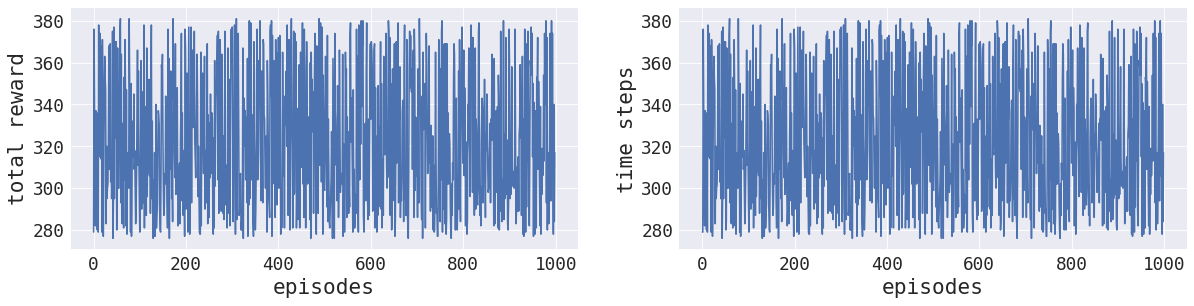

In [4]:
env.result_plot()

# define an observer (new agent)

In [5]:
class par(object):
    def __init__(self):
        self.gamma = 0.995
        self.env_name = "Reacher-v1"
        self.tau = 0.97
        self.l2_reg = 1e-3
        self.max_kl = 1e-2
        self.damping = 1e-1
        self.seed = 543
        self.batch_size = 5000
        self.max_epi = 6000
        self.log_interval = 1
        self.max_avg = 999
        
args = par()
env = adversial_env()
agn = agent(env, args)
#agn.load_model('agent_model/distr_observer')

[2018-03-09 06:26:01,817] Making new env: RoboschoolInvertedPendulum-v1
[2018-03-09 06:26:01,822] Making new env: RoboschoolInvertedPendulum-v1


In [6]:
agn.learn()

8.0 [8.0] [9]
Episode 0	Last reward: 30.0	Average reward 20.98
('lagrange multiplier:', 1.0526028588741907, 'grad_norm:', 0.1908256328084535)
fval before 1.089618054967914e-15
a/e/r 0.020740023445256023 0.021052057177483822 0.9851779933145187
fval after -0.020740023445254933
Episode 1	Last reward: 27.0	Average reward 26.93
('lagrange multiplier:', 1.5406267556481774, 'grad_norm:', 0.2625870003104044)
fval before -7.728891846965521e-16
a/e/r 0.032434510957308704 0.030812535112963512 1.05264012968744
fval after -0.032434510957309474
Episode 2	Last reward: 53.0	Average reward 33.49
('lagrange multiplier:', 1.5795255959669705, 'grad_norm:', 0.28502190234666874)
fval before 4.55285261760367e-16
a/e/r 0.03315455339067743 0.031590511919339245 1.049509848885377
fval after -0.03315455339067697
Episode 3	Last reward: 122.0	Average reward 55.52
('lagrange multiplier:', 1.4649131350912774, 'grad_norm:', 0.27438517553166547)
fval before 2.5865494838891127e-16
a/e/r 0.03015323927561857 0.02929826270

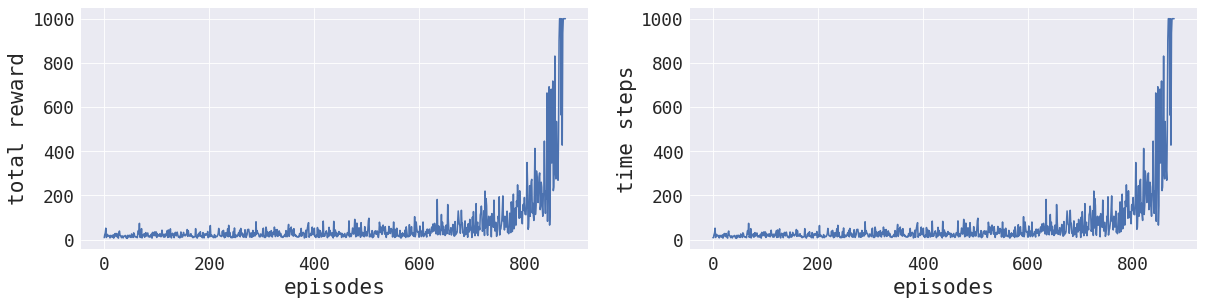

In [7]:
env.result_plot()

# Agent evaluation

In [8]:
env = adversial_env()
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        a = agn.select_action_deterministic(obs)
        obs, r, done, _ = env.step(a)
        if done:
            do = True

        score += r

[2018-03-09 06:27:26,119] Making new env: RoboschoolInvertedPendulum-v1
[2018-03-09 06:27:26,125] Making new env: RoboschoolInvertedPendulum-v1


999.0 [999.0] [1000]


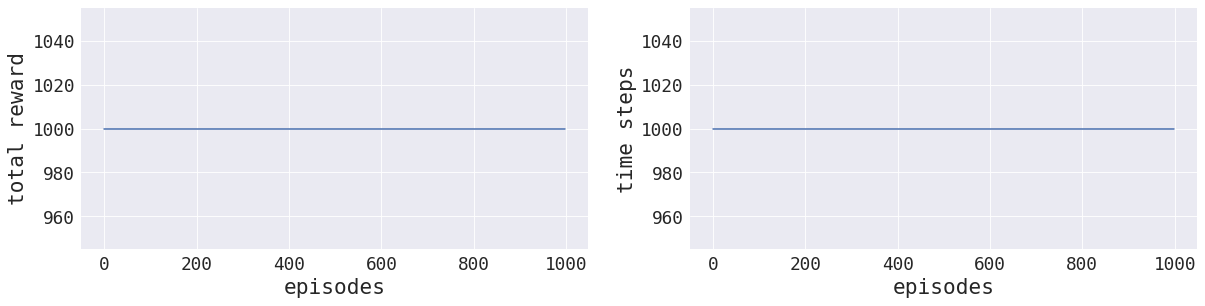

In [9]:
env.result_plot()

# Performance on non-adversarial

In [10]:
env = adversial_env()
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        a = agn.select_action_deterministic(obs)
        obs, r, done, _ = env.non_adstep(a)
        if done:
            do = True

        score += r

[2018-03-09 06:41:02,156] Making new env: RoboschoolInvertedPendulum-v1
[2018-03-09 06:41:02,161] Making new env: RoboschoolInvertedPendulum-v1


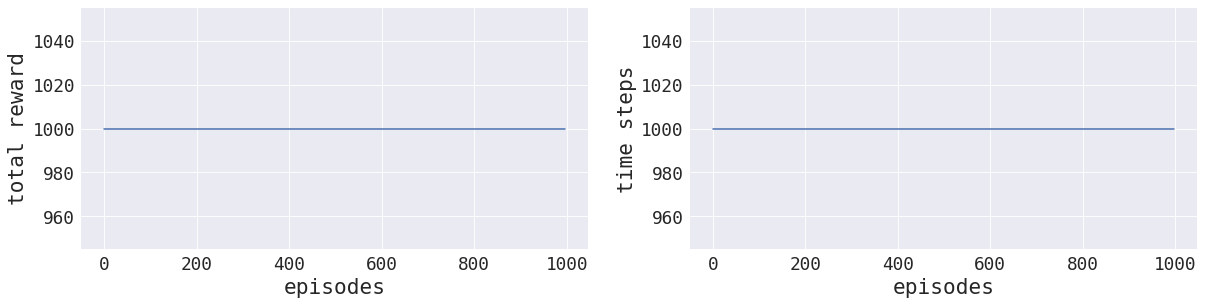

In [11]:
env.result_plot()

# Save model

In [12]:
#agn.save_model('agent_model/distr_observer')